In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn.init as init
import time

In [2]:
def np_to_torch(arr):
    
    arr = torch.FloatTensor(arr)
    arr = arr.unsqueeze(-1)
    arr = arr.clone().detach().requires_grad_(True)
    
    return arr

def x_train_data(N_x, N_t, x_l, x_r):
    
    x_train = np.linspace(x_l, x_r, N_x)
    x_train = np.tile(x_train, N_t)
#     N_xl = mse( torch.where(x_train == x_l,1,0), null ).detach().numpy().item()
    x_train = np_to_torch(x_train)
    
    return x_train

def t_train_data(N_x, N_t, t_i, t_f):
    
    t_train = np.linspace(t_i, t_f, N_t)
    t_train = np.repeat(t_train, N_x)
    t_train = np_to_torch(t_train)

    return t_train
            
def xavier_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.3)
    
class ANN(nn.Module):
    def __init__(self, layer_size):
        super(ANN, self).__init__()
        
        # Fully conected model-1
        modules_1 = []
        for i in range(len(layer_size) - 1):
            modules_1.append(nn.Linear(layer_size[i], layer_size[i+1]))  
            if i < ( len(layer_size) - 2 ):
                modules_1.append(nn.Tanh())
#             else:
#                 modules_1.append(nn.ReLU())

        modules_1.append(nn.Softplus(beta = 2.4))
        self.fc_1 = nn.Sequential(*modules_1)
        for layer in self.fc_1.modules():
            if isinstance(layer, nn.Linear):
                 layer.weight.data.normal_(mean=0.45, std=0.3)
#         self.fc_1.apply(xavier_init)
        
        # Fully conected model-2
        modules_2 = []
        for i in range(len(layer_size) - 1):
            modules_2.append(nn.Linear(layer_size[i], layer_size[i+1]))  
            if i != len(layer_size) - 2 :
                modules_2.append(nn.Tanh())
#             else:
#                 modules_2.append(nn.ReLU())
                
        self.fc_2 = nn.Sequential(*modules_2)
#         self.fc_2.apply(xavier_init)
        for layer in self.fc_1.modules():
            if isinstance(layer, nn.Linear):
                 layer.weight.data.normal_(mean=0, std=0.3)
        
    def forward(self, x_train, t_train):
        
        T = self.fc_1( torch.cat((x_train, t_train),1) )
        dTdx = torch.autograd.grad(T, x_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
        d2Tdx2 = torch.autograd.grad(dTdx, x_train, grad_outputs=torch.ones_like(dTdx), create_graph=True)[0]
        dTdt = torch.autograd.grad(T, t_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
        
        f = self.fc_2( torch.cat((x_train, t_train),1) )
        dfdt = torch.autograd.grad(f, t_train, grad_outputs=torch.ones_like(f), create_graph=True)[0]
        
        return T, dTdx, d2Tdx2, dTdt, f, dfdt
    
def get_loss(x_train, t_train, k1, k2, T_l, T_r, x_l, x_r, t_i, mat_3, mat_4, mat_5, N_3, N_4, N_5, w1, w2, w3, w4, w5, w6):
    
    mse = nn.MSELoss(reduction='sum')
        
    T, dTdx, d2Tdx2, dTdt, f, dfdt  = model(x_train, t_train)
    
    m = nn.Sigmoid()
    
    f_lim = 1
    mat_1 = torch.where(f >= f_lim,1,0)
    N_1 = torch.sum( mat_1 )
    mat_2 = torch.where(f < f_lim,1,0)
    N_2 = torch.sum( mat_2 )
    
    eq1 = w1*( torch.sum( torch.square( torch.mul(mat_1, dTdt - k1*d2Tdx2 ) ) ) 
               )/(N_1) 
    eq2 = w2*torch.sum( torch.square( torch.mul(mat_2, dfdt - k2*d2Tdx2 ) ) )/(N_2)
    bc1 = w3*torch.sum( torch.square( torch.mul(torch.where(x_train == x_l,1,0), T - T_l ) ) )/(20) 
    bc2 = w4*torch.sum( torch.square( torch.mul(mat_3, f - (f_lim + 0.1)  ) ) )/(N_3)
    bc3 = w5*torch.sum( torch.square( torch.mul(mat_2, T - T_r  ) ) )/(N_2) 
    ic1 = w6*torch.sum( torch.square( torch.mul(mat_4, f - 0  ) ) )/(N_4)
    ic2 = w6*torch.sum( torch.square( torch.mul(mat_5, T  ) ) )/(N_5)
# + torch.sum( torch.square( torch.mul(mat_1, m(-30*dTdt) ) ) )
    if (N_1 == 0):
        eq1 = 0
    if (N_2 == 0):
        eq2 = 0
        bc3 = 0
    if (N_3 == 0):
        bc1 = 0
        bc2 = 0
    if (N_4 == 0):
        ic1 = 0

    loss = eq1 + eq2 + bc1 + bc2 + bc3 + ic1 + ic2 
    
    return loss, eq1, eq2, bc1, bc2, bc3, ic1, ic2   

def print_loss(epoch, loss, eq1, eq2, bc1, bc2, bc3, ic1, ic2):
    print('epoch = ',epoch)
    print('loss = ',loss.detach().numpy())
    print('eq1_loss = ',eq1)
    print('eq2_loss = ',eq2.detach().numpy())
    print('bc1_loss = ',bc1.detach().numpy())
    print('bc2_loss = ',bc2.detach().numpy())
    print('bc3_loss = ',bc3.detach().numpy())
    print('ic1_loss = ',ic1.detach().numpy())
    print('ic2_loss = ',ic2.detach().numpy())
    
def lambda_analytical(k1, k2):
    x = []
    er = []
    cnt = 0
    for i in np.arange(0.1, 5, 0.001):
        x.append(i)
        er.append(math.erf(x[-1]))
        cnt = cnt+1

    x = np.array(x)
    er = np.array(er)
    y =[]
    y = np.exp(-x*x)/(er*math.sqrt(math.pi))-x*k1/(k2*2)

    for i in range(1,cnt):
        if(y[i]*y[i-1]<0):
            lam = x[i]
            break
    
    return lam

def analytical(N_x, N_t, x_test, t_test, T_r, k1, k2, T_l):

    x_test = x_test.detach().numpy()
    t_test = t_test.detach().numpy()
    y_an = np.zeros((N_x*N_t, 1))
    lam = lambda_analytical(k1, k2)
    s = np.sqrt(k1*t_test)*2*lam
    
    for j in range(N_x*N_t):
        if(x_test[j]<s[j]):
            y_an[j] = T_l - T_l*math.erf( x_test[j]/( 2*np.sqrt(k1*t_test[j]) ) )/ math.erf(lam) 
        else:
            y_an[j] = T_r
            
    y_an = np.reshape(y_an, (N_x*N_t, 1))
    
    return y_an, s
    
def train_model(model, optimiser1, epochs, T_r, T_l, k1, k2, N_x, x_l, x_r, N_t, t_i, t_f, accuracy_cap):
    
    loss_store = []
    T_store_an = []
    mse = nn.MSELoss(reduction='sum')
    model.train()  
    
    # Initial conditions
    x_train = x_train_data(N_x, N_t, x_l, x_r)
    t_train = t_train_data(N_x, N_t, t_i, t_f)
    mat_3 = torch.mul( torch.where(t_train == t_i,1,0), torch.where(x_train <= 0.01,1,0) )
    N_3 = torch.sum( mat_3 )
    print("N_3 = ", N_3)
    mat_4 = torch.mul( torch.where(t_train == t_i,1,0), torch.where(x_train > 0.01,1,0) )
    N_4 = torch.sum(mat_4)
    print("N_4 = ", N_4)
    mat_5 = torch.mul( torch.where(t_train == t_i,1,0), torch.where(x_train != 0,1,0) )
    N_5 = torch.sum(mat_5)
    print("N_5 = ", N_5)
    # Loss function weights
    w1 = 1
    w2 = 1
    w3 = 1
    w4 = 1
    w5 = 1
    w6 = 1
    
    for epoch in range(epochs):        
    #Backpropogation and optimisation
        loss, eq1, eq2, bc1, bc2, bc3, ic1, ic2 = get_loss(x_train, t_train, k1, k2, T_l, T_r, x_l, x_r, 
                                                      t_i, mat_3, mat_4, mat_5, N_3, N_4, N_5, w1, w2, w3, w4, w5, w6)
        optimiser1.zero_grad()
        loss.backward()
        optimiser1.step()  
        loss_store.append(loss.detach().numpy())
        
        if epoch%2000==0:
            print_loss(epoch, loss, eq1, eq2, bc1, bc2, bc3, ic1, ic2)
            print("")
                    
    # Store the results after each time step
    T_pred, dTdx, d2Tdx2, dTdt, f, dfdt = model(x_train, t_train)
    T_an, _ = analytical(N_x, N_t, x_train, t_train, T_r, k1, k2, T_l)

    return loss_store, T_pred.detach().numpy(), T_an, x_train.detach().numpy(), f.detach().numpy()

In [3]:
N_x = 100
N_t = 40

x_l = 0
x_r = 0.2

T_r = 0
T_l = 1

t_i = 0
t_f = 0.1
accuracy_cap = 0.0004

# Neural network params
layer_size = [2, 6, 6, 1]

# material params
k1 = 0.05
k2 = 0.5

# Training data and initial data
model = ANN(layer_size)
print(model)
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters in the model:", total_trainable_params)

# # Setup Loss function and Optimiser
lr = 8e-5
epochs = 50001
optimiser1 = torch.optim.Adam(model.parameters(), lr=lr)

# Training model
start = time.time()
loss_store, T_store_pred, T_store_an, x_test_np, f = train_model(model, optimiser1, epochs, T_r, T_l, k1, k2, N_x, x_l, x_r, N_t, t_i, t_f, accuracy_cap)
end = time.time()
time_elapsed = end - start
print("time elapsed = ", time_elapsed)

ANN(
  (fc_1): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): Tanh()
    (2): Linear(in_features=6, out_features=6, bias=True)
    (3): Tanh()
    (4): Linear(in_features=6, out_features=1, bias=True)
    (5): Softplus(beta=2.4, threshold=20)
  )
  (fc_2): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): Tanh()
    (2): Linear(in_features=6, out_features=6, bias=True)
    (3): Tanh()
    (4): Linear(in_features=6, out_features=1, bias=True)
  )
)
Total trainable parameters in the model: 134
N_3 =  tensor(5)
N_4 =  tensor(95)
N_5 =  tensor(99)
epoch =  0
loss =  2.4336739
eq1_loss =  0
eq2_loss =  0.009418008
bc1_loss =  1.3229355
bc2_loss =  1.0248349
bc3_loss =  0.034159273
ic1_loss =  0.00792927
ic2_loss =  0.034397107

epoch =  2000
loss =  1.5189974
eq1_loss =  0
eq2_loss =  0.0005248081
bc1_loss =  0.4512147
bc2_loss =  0.2987672
bc3_loss =  0.2418501
ic1_loss =  0.29167902
ic2_loss =  0.23496154

epoch =  4000
loss =  

# Results Plotter

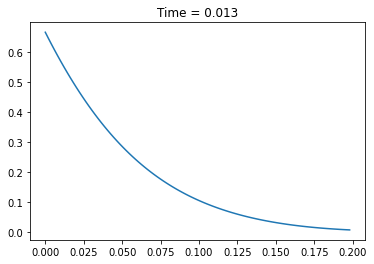

In [12]:
i = 0
plt.plot(x_test_np[i*N_x:(i+1)*N_x-1], T_store_pred[i*N_x:(i+1)*N_x-1])
i = 5
# plt.plot(x_test_np[i*N_x:(i+1)*N_x-1], T_store_pred[i*N_x:(i+1)*N_x-1])
# plt.plot(x_test_np[i*N_x:(i+1)*N_x-1], T_store_an[i*N_x:(i+1)*N_x-1])
t = t_i + (t_f - t_i)/(N_t-1)*(i)
Title = "Time = " + str( "{:.3f}".format (t))
plt.title(Title)
# plt.xlim([0, 0.02])
# plt.legend(["PINN", "Analytical"])
plt.show()

In [5]:
x_train = x_train_data(N_x, N_t, x_l, x_r)
t_train = t_train_data(N_x, N_t, t_i, t_f)
T, dTdx, d2Tdx2, dTdt, f, dfdt  = model(x_train, t_train)

In [6]:
for i in range(200):
    print(d2Tdx2[i])

tensor([110.4355], grad_fn=<SelectBackward0>)
tensor([109.9076], grad_fn=<SelectBackward0>)
tensor([109.3230], grad_fn=<SelectBackward0>)
tensor([108.6806], grad_fn=<SelectBackward0>)
tensor([107.9794], grad_fn=<SelectBackward0>)
tensor([107.2187], grad_fn=<SelectBackward0>)
tensor([106.3981], grad_fn=<SelectBackward0>)
tensor([105.5174], grad_fn=<SelectBackward0>)
tensor([104.5766], grad_fn=<SelectBackward0>)
tensor([103.5761], grad_fn=<SelectBackward0>)
tensor([102.5166], grad_fn=<SelectBackward0>)
tensor([101.3988], grad_fn=<SelectBackward0>)
tensor([100.2241], grad_fn=<SelectBackward0>)
tensor([98.9940], grad_fn=<SelectBackward0>)
tensor([97.7101], grad_fn=<SelectBackward0>)
tensor([96.3747], grad_fn=<SelectBackward0>)
tensor([94.9899], grad_fn=<SelectBackward0>)
tensor([93.5583], grad_fn=<SelectBackward0>)
tensor([92.0825], grad_fn=<SelectBackward0>)
tensor([90.5657], grad_fn=<SelectBackward0>)
tensor([89.0107], grad_fn=<SelectBackward0>)
tensor([87.4210], grad_fn=<SelectBackward0